# COGS 14P Final Project: Adaptive Procedure for Threshold Estimation
#### Name: Ellis Liang

In [2]:
import numpy as np
from numpy import random 
import pandas as pd
import simpleaudio as sa
from math import sqrt
from matplotlib import pyplot as plt

## Part One: Constructing the experiment with a two-down one-up procedure

### Experiment Parameters

In [3]:
subjid = '1' #numerical label for the subject
rng = random.default_rng(seed = int(subjid)) #the seed used for randomizing each subject's trials
base_frequency_A = 1760 #starting A_note, will either be 440Hz, 880Hz, or 1760Hz
df = 0.10 #starting frequency difference as a decimal
num_training_trials = 5 #practice trials at the beginning of each subject's trial
max_reversals = 4 #maximum number of incorrect answers the subject gets before the program terminates
max_trials = 50 #maximum number of trials to run if the max_reversal is never reached

### Construct the functions to be used in the program

In [4]:
def make_tone(f,duration = 0.5,sr = 44100,ramp = 200):
    time_vec = np.linspace(0, duration, int(duration*sr)) 
    tone = np.sin(f * time_vec  * 2 * np.pi)
    risingramp = np.linspace(0,1,ramp)
    descendingramp = np.linspace(1,0,ramp)
    tone[0:ramp] = tone[0:ramp]*risingramp
    tone[-ramp:] = tone[-ramp:]*descendingramp
    return tone

In [5]:
def play_sound(tone,volume = 0.05,sr = 44100):
    tone  = tone*32768 / np.max(np.abs(tone))  
    tone = volume*tone
    tone  = tone.astype(np.int16) 
    play_obj = sa.play_buffer(tone , 1, 2, sr) 
    play_obj.wait_done() 

In [6]:
def collect_response():
    response = input('Enter 1 if the first tone is higher and 2 if the second tone is higher')
    return response

In [7]:
def check_response(response, condition): #return True if correct, False if incorrect
    is_correct = False
    if response == condition:
        is_correct = True
    return is_correct

In [8]:
def make_stimulus(fA, df): #make the frequencies for the two tones A and B
    A_note = make_tone(fA)
    deltaf = fA * df
    fB = fA + deltaf
    B_note = make_tone(fB)
    silence = np.zeros(int(0.25*44100))
    return A_note, B_note

### Create empty lists to hold information about the subject and the trial

In [10]:
training_responses = []
df_list = []
responses = []
correct_answers = []
conditions_list = []


### In the first five trials, df will not change, in order to verify that the subject understood the instructions

In [96]:
for i in range(num_training_trials):
    my_num = rng.integers(1, 3, 1)
    A_note, B_note = make_stimulus(base_frequency_A, df)
    
    if my_num % 2 == 0:
        play_sound(A_note)
        play_sound(B_note)
    else:
        play_sound(B_note)
        play_sound(A_note)

    response = collect_response()
    training_responses.append(response)
print(training_responses)


['1', '2', '2', '2', '1']


### At this point, the staircase procedure begins, where two consecutive correct answers will make the experiment more difficult, and one incorrect answer will make it easier. 

In [14]:
consec_correct = 0
reversals = 0
for n in range(max_trials):
    my_num = rng.integers(1, 3, 1)
    A_note, B_note = make_stimulus(base_frequency_A, df)
    df_list.append(df) #save the order of the differences in frequency in a list

    if my_num % 2 == 0:
        play_sound(A_note)
        play_sound(B_note)
        condition = '2' #B is the higher note
        correct_answers.append(condition) #save the correct answers in a list
        conditions_list.append(['A', 'B']) #save the order in which the sounds are played in a list of lists
    else:
        play_sound(B_note) #high note plays first
        play_sound(A_note)
        condition = '1'
        correct_answers.append(condition)
        conditions_list.append(['B', 'A'])

    response = collect_response() #save all of the subject's answers
    responses.append(response)
    is_correct = check_response(response, condition) #the function will return True if the subject's answer is correct, otherwise False
    
    if is_correct == False: #this block runs if the subject gets an answer wrong
        df = df * (sqrt(2))
        consec_correct = 0
        reversals = reversals + 1
        if reversals == max_reversals:
            break #breaks the loop when the subject makes a set amount of errors (aka reversals that decrease df)
    elif is_correct == True: #resets counter for consecutive incorrect answers and increments counter for consecutive correct
        consec_correct = consec_correct + 1
        reversals = 0
    if consec_correct == 2:
        df = df / (sqrt(2))
        consec_correct = 0


print('Trials complete!')

Trials complete!


In [15]:
print('Subject\'s responses: ', responses)
print('Correct answers: ', correct_answers)
print('Base frequency of stimulus A: ', base_frequency_A, 'Hz')
print('Frequency difference \'df\': ', df_list)

Subject's responses:  ['1', '2', '2', '2', '1', '1', '2', '2', '1', '1', '2', '1', '1', '2', '1', '1', '2', '2', '1', '1', '2', '2', '2', '2', '1', '2', '1', '2', '2', '2', '2', '2']
Correct answers:  ['1', '2', '2', '2', '1', '1', '2', '2', '1', '1', '2', '1', '1', '2', '1', '1', '2', '2', '1', '1', '2', '2', '2', '2', '2', '1', '1', '2', '1', '1', '1', '1']
Base frequency of stimulus A:  1760 Hz
Frequency difference 'df':  [0.1, 0.1, 0.07071067811865475, 0.07071067811865475, 0.049999999999999996, 0.049999999999999996, 0.03535533905932737, 0.03535533905932737, 0.024999999999999994, 0.024999999999999994, 0.017677669529663684, 0.017677669529663684, 0.012499999999999997, 0.012499999999999997, 0.008838834764831842, 0.008838834764831842, 0.006249999999999999, 0.006249999999999999, 0.004419417382415921, 0.004419417382415921, 0.0031249999999999993, 0.0031249999999999993, 0.0022097086912079606, 0.0022097086912079606, 0.0015624999999999997, 0.0022097086912079606, 0.0031249999999999997, 0.00312

### Create data frames

In [16]:
data = pd.DataFrame(columns = ['Stimulus Level (df)','Response','Correct_Response']) #create an empty data frame with three columns with column labels given
data['Stimulus Level (df)'] = df_list #place trial_order in the 'Condition' column
data['Response'] = responses #place trial_response in the 'Response' column
data['Correct_Response'] = correct_answers

### Write to a file and repeat experiment for other base frequencies

In [17]:
filename = f'SoundExperiment_{subjid}_{base_frequency_A}.csv'
data.to_csv(filename) #write it out to a csv file 

## Part Two: Create the data analysis program

### Compute the mean of the stimulus level (df) from the 2nd reversal to the 4th reversal. This is the estimate of the threshold for 70.7% performance.

### This should be done 3 times, once for each base frequency that the experiment occurs. A bar graph should show the frequency difference for the 3 frequencies.

### Find the stimulus level (df) for the 2nd reversal to 4th reversal

In [19]:
trial_1 = pd.read_csv('SoundExperiment_1_440.csv')
stim_level1 = trial_1['Stimulus Level (df)']

trial_2 = pd.read_csv('SoundExperiment_1_880.csv')
stim_level2 = trial_2['Stimulus Level (df)']

trial_3 = pd.read_csv('SoundExperiment_1_1760.csv')
stim_level3 = trial_3['Stimulus Level (df)']


In [ ]:
for i in trial_1['']

### Compute the mean

In [20]:
mean_df1 = np.mean(stim_level1[-3:])
print(mean_df1)
mean_df2 = np.mean(stim_level2[-3:])
print(mean_df2)
mean_df3 = np.mean(stim_level3[-3:])
print(mean_df3)

0.0065027507157492
0.004598139127471933
0.004598139127471933


### Make a graph of the frequency difference for all trials

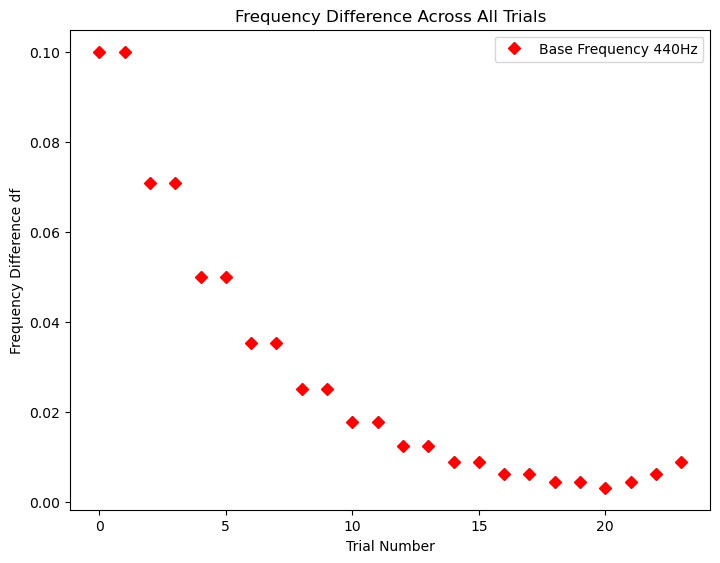

In [34]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(np.arange(0, 24, 1), stim_level1, 'rD', label='Base Frequency 440Hz')
ax.set_xlabel('Trial Number')
ax.set_ylabel('Frequency Difference df')
ax.set_title('Frequency Difference Across All Trials')
ax.legend()

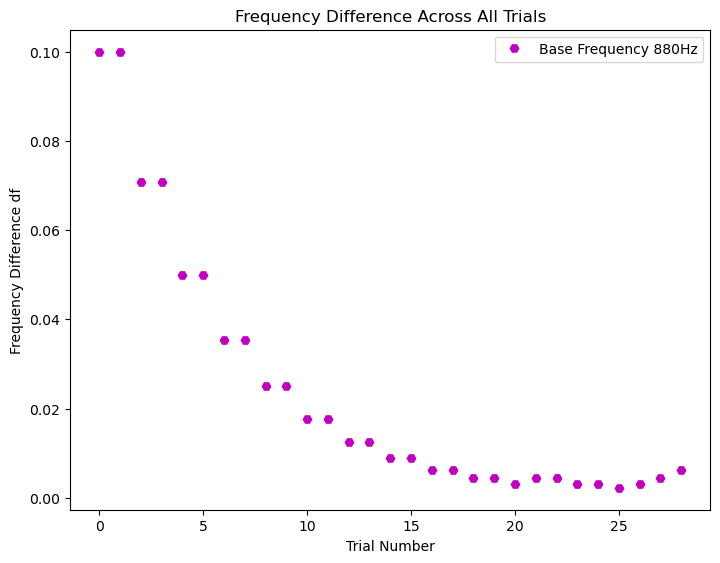

In [35]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(np.arange(0, 29, 1), stim_level2, 'mH', label='Base Frequency 880Hz')
ax.set_xlabel('Trial Number')
ax.set_ylabel('Frequency Difference df')
ax.set_title('Frequency Difference Across All Trials')
ax.legend()

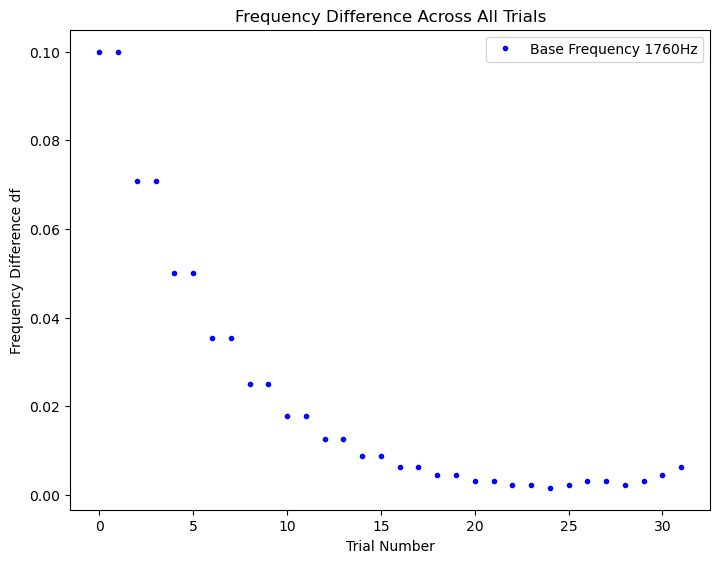

In [33]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(np.arange(0, 32, 1), stim_level3, 'b.', label='Base Frequency 1760Hz')
ax.set_xlabel('Trial Number')
ax.set_ylabel('Frequency Difference df')
ax.set_title('Frequency Difference Across All Trials')
ax.legend()

### Create a bar graph showing the frequency difference (df) for the 3 base frequencies

Text(0.5, 1.0, 'Frequency Difference per Base Frequency')

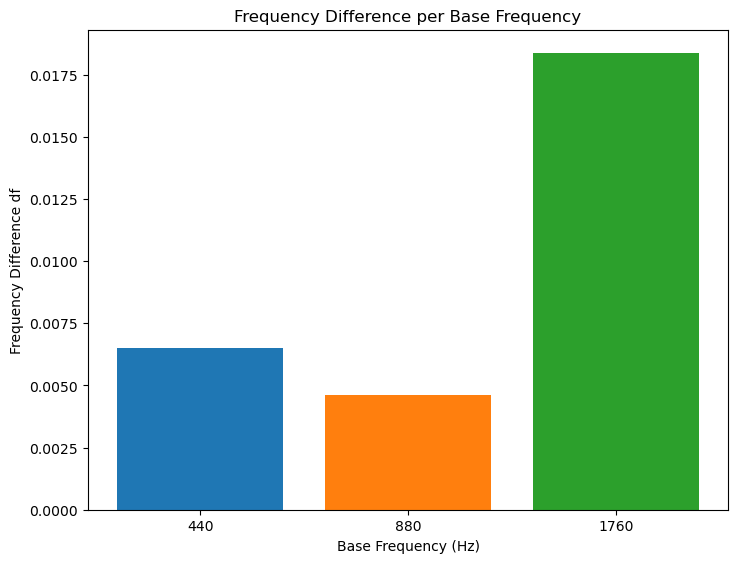

In [76]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar('440', mean_df1)
ax.bar('880', mean_df2)
ax.bar('1760', mean_df3)
ax.set_xlabel('Base Frequency (Hz)')
ax.set_ylabel('Frequency Difference df')
ax.set_title('Frequency Difference per Base Frequency')